Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 16.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 12.9 MB/s 
     |████████████████████████████████| 6.6 MB 71.4 MB/s 
     |████████████████████████████████| 120 kB 89.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.2 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=ed0f57ca353a8b6ebb15f97a91d6caac1b41f8689c6e5e9ea8f0c25d9519d297
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1hIe1NaUcYENwTFrG_z1WUEiEkEzhtzbx'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1fbR_cCVnnvMiJuaS7tvGE8nHHepciFuG'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1cz6lxw3dd-zeoKtLewT7pjSkIIh4BjOe'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1W3P_xzWN4P3YTFvHqw0wY-PUClLXne1K'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="utf-8")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="utf-8")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="utf-8")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  226
Number of dev sentences:  40
Number of test sentences:  48
Number of words in the training dataset:  5862
Number of words in the dev dataset:  1874
Number of words in the test dataset:  2030
Tags in the training dataset: ['B-AGMT_DATE', 'I-AGMT_DATE', 'I-PARTY', 'I-DOC_NAME', 'B-PARTY', 'O', 'B-DOC_NAME']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['B-AGMT_DATE', 'I-AGMT_DATE', 'I-PARTY', 'I-DOC_NAME', 'B-PARTY', 'O', 'B-DOC_NAME']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['B-AGMT_DATE', 'I-AGMT_DATE', 'I-PARTY', 'I-DOC_NAME', 'B-PARTY', 'O', 'B-DOC_NAME']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 1,Exhibit,O
1,Sentence: 1,99.1,O
2,Sentence: 1,JOINT,B-DOC_NAME
3,Sentence: 1,FILING,I-DOC_NAME
4,Sentence: 1,AGREEMENT,I-DOC_NAME
5,Sentence: 1,The,O
6,Sentence: 1,undersigned,O
7,Sentence: 1,hereby,O
8,Sentence: 1,agree,O
9,Sentence: 1,that,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Exhibit', 'O'),
 ('10.8', 'O'),
 ('Services', 'B-DOC_NAME'),
 ('Agreement', 'I-DOC_NAME'),
 ('Oaktree', 'B-PARTY'),
 ('Capital', 'I-PARTY'),
 ('Management', 'I-PARTY'),
 (',', 'I-PARTY'),
 ('L.P.', 'I-PARTY'),
 ('and', 'O'),
 ('Oaktree', 'B-PARTY'),
 ('Capital', 'I-PARTY'),
 ('Management', 'I-PARTY'),
 ('(', 'I-PARTY'),
 ('International', 'I-PARTY'),
 (')', 'I-PARTY'),
 ('Limited', 'I-PARTY'),
 ('September', 'O'),
 ('2018', 'O'),
 ('1', 'O'),
 ('THIS', 'O'),
 ('SERVICES', 'B-DOC_NAME'),
 ('AGREEMENT', 'I-DOC_NAME'),
 ('(', 'O'),
 ('this', 'O'),
 ('“', 'O'),
 ('Agreement', 'O'),
 ('”', 'O'),
 (')', 'O'),
 ('is', 'O'),
 ('made', 'O'),
 ('on', 'O'),
 ('25', 'B-AGMT_DATE'),
 ('September', 'I-AGMT_DATE'),
 ('2018', 'I-AGMT_DATE'),
 ('BETWEEN', 'O'),
 (':', 'O'),
 ('(', 'O'),
 ('1', 'O'),
 (')', 'O'),
 ('Oaktree', 'B-PARTY'),
 ('Capital', 'I-PARTY'),
 ('Management', 'I-PARTY'),
 (',', 'I-PARTY'),
 ('L.P.', 'I-PARTY'),
 ('a', 'O'),
 ('Delaware', 'O'),
 ('limited', 'O'),
 ('partnership', 'O

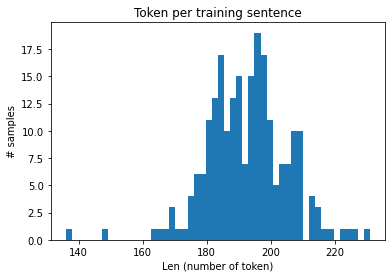

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

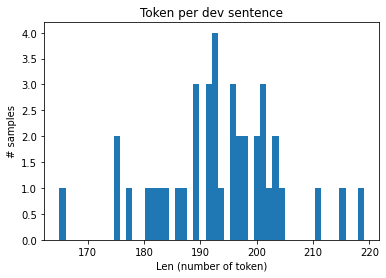

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

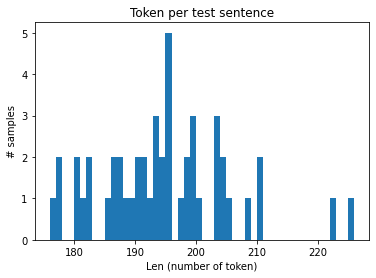

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'business'
print(word2idx['business'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-PARTY'
print(tag2idx['B-PARTY'])
# Tag of index 2
print(idx2tag[2])

583
Skype
4
I-PARTY


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.77876)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 226
Points in y_train before removal: 226
Points in X_train before removal: 50
Points in y_train before removal: 50


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['business'])
print(tag2idx['B-PARTY'])
print(idx2tag[2])
print(idx2word[10])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[6652, 5083, 4208, 755, 7066, 7010, 3347, 4208, 755, 7066, 7010, 3583, 4598, 396, 4223, 396, 5534, 7106, 728, 4826, 6867, 4877, 5361, 6921, 3469, 3583, 4598, 396, 4074, 3096, 396, 5534, 6921, 1409, 3836, 1910, 4897, 3181, 6921, 4367, 4890, 6921, 4654, 7215, 2981, 6103, 4654, 3042, 6867, 583, 880, 705, 4636, 3403, 1303, 1037, 6921, 3088, 7136, 6921, 2990, 2290, 3583, 396, 3414, 396, 5534, 6921, 3836, 661, 6921, 4367, 4890, 6921, 4654, 7215, 2981, 6921, 6103, 5861, 1579, 3042, 6867, 583, 880, 6520, 3568, 6602, 1403, 6921, 1303, 1125, 6921, 4461, 6492, 6921, 435, 1079, 3583, 396, 2760, 396, 5534, 4890, 4648, 6921, 2760, 3556, 4654, 2434, 1268, 4598, 3732, 6921, 2029, 3699, 880, 6996, 3583, 4598, 396, 2760, 3656, 396, 5534, 6921, 2440, 844, 6105, 3856, 3836, 3872, 1268, 755, 4634, 4648, 6921, 3414, 3556, 310, 1268, 4598, 3732, 6921, 2029, 3699, 880, 5815, 3583, 4598, 396, 3414, 1526, 396, 5534, 6921, 2440, 844, 5998, 1268, 755, 6456, 158, 4441, 6500, 6921, 452, 4392, 6921, 6836, 6921, 4776

In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1W3P_xzWN4P3YTFvHqw0wY-PUClLXne1K'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].replace("_CWR","")

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['business'])
print(tag2idx['B-PARTY'])
print(idx2tag[2])
print(idx2word[10])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[6652, 5083, 4208, 755, 7066, 7010, 3347, 4208, 755, 7066, 7010, 3583, 4598, 396, 4223, 396, 5534, 7106, 728, 4826, 6867, 4877, 5361, 6921, 3469, 3583, 4598, 396, 4074, 3096, 396, 5534, 6921, 1409, 3836, 1910, 4897, 3181, 6921, 4367, 4890, 6921, 4654, 7215, 2981, 6103, 4654, 3042, 6867, 583, 880, 705, 4636, 3403, 1303, 1037, 6921, 3088, 7136, 6921, 2990, 2290, 3583, 396, 3414, 396, 5534, 6921, 3836, 661, 6921, 4367, 4890, 6921, 4654, 7215, 2981, 6921, 6103, 5861, 1579, 3042, 6867, 583, 880, 6520, 3568, 6602, 1403, 6921, 1303, 1125, 6921, 4461, 6492, 6921, 435, 1079, 3583, 396, 2760, 396, 5534, 4890, 4648, 6921, 2760, 3556, 4

In [2]:
from transformers import pipeline
from future.utils import iteritems

# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    unmasker = pipeline('fill-mask', model='bert-base-multilingual-cased')
    
    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
      sequence_str = [idx2word[word] for word in sequence]
      replaceable_indices = [i for i,label in enumerate(base_labels[k]) if label == tag2idx["O"]]
      replace_percent = round(random.uniform(0.1, 1), 1)
      replace_qty = max(math.floor(replace_percent*len(replaceable_indices)), 1)
      replace_indices = random.sample(replaceable_indices, k=replace_qty)
      replace_indices.sort()

      masked_text_list = ["[MASK]" if i in replace_indices else word for i,word in enumerate(sequence_str)]
      new_mask_sent = ' '.join(masked_text_list)
      augmented_text_list = unmasker(new_mask_sent)

      augmented_sentence = sequence_str.copy()
      if len(replace_indices) == 1:
        augmented_text_list = [augmented_text_list]

      for i,index in enumerate(replace_indices):
        available_words = [word["token_str"] for word in augmented_text_list[i] if word["token_str"] != sequence_str[index]]
        new_word = random.choice(available_words)
        augmented_sentence[index] = new_word

      # print("Original text->",sequence_str)
      # print("Augmented text->",augmented_sentence)

      new_sequences.append(augmented_sentence)
      new_labels.append(base_labels[k])

    all_words = list(set([word for seq in new_sequences for word in seq]))
    updated_word2idx = word2idx.copy()
    updated_idx2word = idx2word.copy()
    for word in all_words:
      try:
        updated_word2idx[word]
      except:
        updated_word2idx[word] = len(updated_word2idx)
    updated_idx2word = {i: w for w, i in iteritems(updated_word2idx)}

    new_sequences = [[updated_word2idx[word] for word in seq] for seq in new_sequences]

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train, updated_word2idx, updated_idx2word

In [3]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [4]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('bert-base-multilingual-cased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 16:
    TRAIN_BATCH_SIZE = 16
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 16:
    VALID_BATCH_SIZE = 16
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [5]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [6]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [7]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train, updated_word2idx, updated_idx2word = generate_sentences(X_train, y_train, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  if maxlen > 512:
    maxlen = 512

  augmented_X_train_words = [[updated_idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[updated_idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[updated_idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [8]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0452651977539062
Training loss epoch: 0.7840408640248435
Training accuracy epoch: 0.7551533625126854
Validating model...
Validation Loss: 0.43944230675697327
Validation Accuracy: 0.8662647343171064
Training epoch: 2
Training loss per 100 training steps: 0.3856349587440491
Training loss epoch: 0.31519438113485065
Training accuracy epoch: 0.9031633577433356
Validating model...
Validation Loss: 0.22481824085116386
Validation Accuracy: 0.9279589018761563
Training epoch: 3
Training loss per 100 training steps: 0.20792075991630554
Training loss epoch: 0.17635478505066463
Training accuracy epoch: 0.9424771356190166
Validating model...
Validation Loss: 0.1577993929386139
Validation Accuracy: 0.9463044932719815
Training epoch: 4
Training loss per 100 training steps: 0.12728549540042877
Training loss epoch: 0.11778898004974638
Training accuracy epoch: 0.9636998224676664
Validating model...
Validation Loss: 0.11576968990266323
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08193057477474212
Validation Accuracy: 0.9778201394858765
Validation duration: 0.007855733333333366 minutes
F1-score (test): 79.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.88      0.87        50
    DOC_NAME       0.74      0.80      0.77        82
       PARTY       0.74      0.83      0.78       122

   micro avg       0.76      0.83      0.79       254
   macro avg       0.78      0.84      0.81       254
weighted avg       0.76      0.83      0.80       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8990044593811035
Training loss epoch: 0.8388565225260598
Training accuracy epoch: 0.7789910085771936
Validating model...
Validation Loss: 0.5542233884334564
Validation Accuracy: 0.8635165790147409
Training epoch: 2
Training loss per 100 training steps: 0.618906557559967
Training loss epoch: 0.45453414746693205
Training accuracy epoch: 0.8770653569066814
Validating model...
Validation Loss: 0.3557833731174469
Validation Accuracy: 0.882364758802408
Training epoch: 3
Training loss per 100 training steps: 0.3636826276779175
Training loss epoch: 0.2735247952597482
Training accuracy epoch: 0.9200860736391713
Validating model...
Validation Loss: 0.20098751410841942
Validation Accuracy: 0.9352235578895709
Training epoch: 4
Training loss per 100 training steps: 0.19406886398792267
Training loss epoch: 0.17082555485623224
Training accuracy epoch: 0.942549504180518
Validating model...
Validation Loss: 0.14268594421446323
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1077089324593544
Validation Accuracy: 0.9783409821274738
Validation duration: 0.007791833333333168 minutes
F1-score (test): 81.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.92      0.91        50
    DOC_NAME       0.76      0.84      0.80        82
       PARTY       0.72      0.89      0.80       122

   micro avg       0.77      0.88      0.82       254
   macro avg       0.80      0.88      0.84       254
weighted avg       0.77      0.88      0.82       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1519250869750977
Training loss epoch: 0.8477694732802254
Training accuracy epoch: 0.758560266378114
Validating model...
Validation Loss: 0.5624609291553497
Validation Accuracy: 0.8636706730015649
Training epoch: 2
Training loss per 100 training steps: 0.6204808950424194
Training loss epoch: 0.46073925495147705
Training accuracy epoch: 0.8745125523384134
Validating model...
Validation Loss: 0.33772581815719604
Validation Accuracy: 0.8888522309185385
Training epoch: 3
Training loss per 100 training steps: 0.3573002219200134
Training loss epoch: 0.2695685901812145
Training accuracy epoch: 0.9229739678173493
Validating model...
Validation Loss: 0.21687856316566467
Validation Accuracy: 0.929776732442718
Training epoch: 4
Training loss per 100 training steps: 0.17405281960964203
Training loss epoch: 0.17641543277672359
Training accuracy epoch: 0.941000321998672
Validating model...
Validation Loss: 0.16685643047094345
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09572052359580993
Validation Accuracy: 0.9781138209393119
Validation duration: 0.007674116666666464 minutes
F1-score (test): 81.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.80      0.82      0.81        50
    DOC_NAME       0.75      0.84      0.79        82
       PARTY       0.79      0.85      0.82       122

   micro avg       0.78      0.84      0.81       254
   macro avg       0.78      0.84      0.81       254
weighted avg       0.78      0.84      0.81       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1669387817382812
Training loss epoch: 0.8801923394203186
Training accuracy epoch: 0.750486037569659
Validating model...
Validation Loss: 0.5184347778558731
Validation Accuracy: 0.8630695488408606
Training epoch: 2
Training loss per 100 training steps: 0.48899951577186584
Training loss epoch: 0.4386000462940761
Training accuracy epoch: 0.8782323769463448
Validating model...
Validation Loss: 0.3065163940191269
Validation Accuracy: 0.902407903141899
Training epoch: 3
Training loss per 100 training steps: 0.29862356185913086
Training loss epoch: 0.24809151887893677
Training accuracy epoch: 0.9252956137351368
Validating model...
Validation Loss: 0.2002164050936699
Validation Accuracy: 0.9314638214062652
Training epoch: 4
Training loss per 100 training steps: 0.17073410749435425
Training loss epoch: 0.15658891201019287
Training accuracy epoch: 0.9460909435114642
Validating model...
Validation Loss: 0.17761285416781902
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09820224121212959
Validation Accuracy: 0.9777321968716922
Validation duration: 0.007770683333332803 minutes
F1-score (test): 80.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.78      0.78      0.78        50
    DOC_NAME       0.76      0.85      0.80        82
       PARTY       0.76      0.85      0.81       122

   micro avg       0.77      0.84      0.80       254
   macro avg       0.77      0.83      0.80       254
weighted avg       0.77      0.84      0.80       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.2223236560821533
Training loss epoch: 0.8312307255608695
Training accuracy epoch: 0.7541194845173702
Validating model...
Validation Loss: 0.45553184300661087
Validation Accuracy: 0.8636979833686858
Training epoch: 2
Training loss per 100 training steps: 0.5038796067237854
Training loss epoch: 0.35398058593273163
Training accuracy epoch: 0.8897901499831036
Validating model...
Validation Loss: 0.250995147973299
Validation Accuracy: 0.9241655909750653
Training epoch: 3
Training loss per 100 training steps: 0.2276069074869156
Training loss epoch: 0.19323372840881348
Training accuracy epoch: 0.9369975042895841
Validating model...
Validation Loss: 0.16928526014089584
Validation Accuracy: 0.9423414183213787
Training epoch: 4
Training loss per 100 training steps: 0.14519372582435608
Training loss epoch: 0.12997419919286454
Training accuracy epoch: 0.956091675500582
Validating model...
Validation Loss: 0.1360263079404831
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10270691812038421
Validation Accuracy: 0.9768559530423518
Validation duration: 0.007870849999999525 minutes
F1-score (test): 78.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.88      0.88        50
    DOC_NAME       0.73      0.82      0.77        82
       PARTY       0.69      0.85      0.76       122

   micro avg       0.74      0.85      0.79       254
   macro avg       0.77      0.85      0.80       254
weighted avg       0.74      0.85      0.79       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1021318435668945
Training loss epoch: 0.8688451732907977
Training accuracy epoch: 0.7588476939385828
Validating model...
Validation Loss: 0.5141262412071228
Validation Accuracy: 0.8635676467176382
Training epoch: 2
Training loss per 100 training steps: 0.45279210805892944
Training loss epoch: 0.429044565984181
Training accuracy epoch: 0.8734190377931232
Validating model...
Validation Loss: 0.3090134784579277
Validation Accuracy: 0.9063337660193591
Training epoch: 3
Training loss per 100 training steps: 0.29925957322120667
Training loss epoch: 0.2571219950914383
Training accuracy epoch: 0.9279664133168825
Validating model...
Validation Loss: 0.2340717874467373
Validation Accuracy: 0.9310642266146163
Training epoch: 4
Training loss per 100 training steps: 0.21648313105106354
Training loss epoch: 0.15867768228054047
Training accuracy epoch: 0.948992133691337
Validating model...
Validation Loss: 0.1671426184475422
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09693640172481537
Validation Accuracy: 0.9778321830124359
Validation duration: 0.007698266666666124 minutes
F1-score (test): 81.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.88      0.87        50
    DOC_NAME       0.79      0.85      0.82        82
       PARTY       0.75      0.84      0.79       122

   micro avg       0.78      0.85      0.82       254
   macro avg       0.80      0.86      0.83       254
weighted avg       0.78      0.85      0.82       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0157313346862793
Training loss epoch: 0.8071888940674918
Training accuracy epoch: 0.7564903068981653
Validating model...
Validation Loss: 0.4936886876821518
Validation Accuracy: 0.8635495023046664
Training epoch: 2
Training loss per 100 training steps: 0.49712279438972473
Training loss epoch: 0.37822837488991873
Training accuracy epoch: 0.8884463627363784
Validating model...
Validation Loss: 0.26014650613069534
Validation Accuracy: 0.9182098150932951
Training epoch: 3
Training loss per 100 training steps: 0.21508550643920898
Training loss epoch: 0.22433376738003322
Training accuracy epoch: 0.9309512065124034
Validating model...
Validation Loss: 0.20839734375476837
Validation Accuracy: 0.9305977686388497
Training epoch: 4
Training loss per 100 training steps: 0.17793725430965424
Training loss epoch: 0.1608748393399375
Training accuracy epoch: 0.9503173201672602
Validating model...
Validation Loss: 0.15718217380344868
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08625871241092682
Validation Accuracy: 0.9798820160594927
Validation duration: 0.0076195166666669445 minutes
F1-score (test): 82.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.86      0.84        50
    DOC_NAME       0.80      0.88      0.84        82
       PARTY       0.74      0.87      0.80       122

   micro avg       0.78      0.87      0.82       254
   macro avg       0.79      0.87      0.83       254
weighted avg       0.78      0.87      0.82       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9462826251983643
Training loss epoch: 0.7515472003391811
Training accuracy epoch: 0.7783807954412933
Validating model...
Validation Loss: 0.4245835244655609
Validation Accuracy: 0.8674771762848559
Training epoch: 2
Training loss per 100 training steps: 0.42224401235580444
Training loss epoch: 0.3224875714097704
Training accuracy epoch: 0.9006069028794347
Validating model...
Validation Loss: 0.21855462342500687
Validation Accuracy: 0.9308935676262127
Training epoch: 3
Training loss per 100 training steps: 0.18087562918663025
Training loss epoch: 0.18600759761674063
Training accuracy epoch: 0.9405782727922418
Validating model...
Validation Loss: 0.16833706945180893
Validation Accuracy: 0.9375460448889847
Training epoch: 4
Training loss per 100 training steps: 0.14970313012599945
Training loss epoch: 0.12024670626435961
Training accuracy epoch: 0.9576160933422929
Validating model...
Validation Loss: 0.13087341003119946
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11292047947645187
Validation Accuracy: 0.973621106478371
Validation duration: 0.007795666666666534 minutes
F1-score (test): 76.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.76      0.78      0.77        50
    DOC_NAME       0.68      0.66      0.67        82
       PARTY       0.76      0.87      0.81       122

   micro avg       0.74      0.78      0.76       254
   macro avg       0.73      0.77      0.75       254
weighted avg       0.73      0.78      0.76       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.2880966663360596
Training loss epoch: 0.8624633550643921
Training accuracy epoch: 0.753334600378088
Validating model...
Validation Loss: 0.5022471621632576
Validation Accuracy: 0.8634062670202959
Training epoch: 2
Training loss per 100 training steps: 0.5046355724334717
Training loss epoch: 0.4031267293861934
Training accuracy epoch: 0.8835181224830448
Validating model...
Validation Loss: 0.2808966264128685
Validation Accuracy: 0.9265274267429805
Training epoch: 3
Training loss per 100 training steps: 0.31117677688598633
Training loss epoch: 0.21792239802224295
Training accuracy epoch: 0.9359839157742444
Validating model...
Validation Loss: 0.195795938372612
Validation Accuracy: 0.9316215209760922
Training epoch: 4
Training loss per 100 training steps: 0.18710662424564362
Training loss epoch: 0.15103514066764287
Training accuracy epoch: 0.948066769296503
Validating model...
Validation Loss: 0.1566949598491192
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1046730101108551
Validation Accuracy: 0.9764341504078026
Validation duration: 0.007691583333333559 minutes
F1-score (test): 79.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.79      0.84      0.82        50
    DOC_NAME       0.72      0.80      0.76        82
       PARTY       0.76      0.88      0.82       122

   micro avg       0.75      0.85      0.80       254
   macro avg       0.76      0.84      0.80       254
weighted avg       0.75      0.85      0.80       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0118398666381836
Training loss epoch: 0.8491419468607221
Training accuracy epoch: 0.7664465110723314
Validating model...
Validation Loss: 0.6221528947353363
Validation Accuracy: 0.8633898707002526
Training epoch: 2
Training loss per 100 training steps: 0.5738364458084106
Training loss epoch: 0.5542773944990975
Training accuracy epoch: 0.879083887804861
Validating model...
Validation Loss: 0.5423795655369759
Validation Accuracy: 0.8636351033441408
Training epoch: 3
Training loss per 100 training steps: 0.5055304765701294
Training loss epoch: 0.4482083320617676
Training accuracy epoch: 0.8812028192950146
Validating model...
Validation Loss: 0.384709894657135
Validation Accuracy: 0.8765512997249413
Training epoch: 4
Training loss per 100 training steps: 0.30642810463905334
Training loss epoch: 0.28998322572026936
Training accuracy epoch: 0.914680180984197
Validating model...
Validation Loss: 0.24467532336711884
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10327830016613007
Validation Accuracy: 0.9761482772725539
Validation duration: 0.007713516666666464 minutes
F1-score (test): 78.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.76      0.78      0.77        50
    DOC_NAME       0.72      0.77      0.74        82
       PARTY       0.78      0.86      0.82       122

   micro avg       0.76      0.81      0.79       254
   macro avg       0.75      0.80      0.78       254
weighted avg       0.76      0.81      0.79       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [9]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.7740932703018188
Training loss epoch: 0.7248548083007336
Training accuracy epoch: 0.8081995097318768
Validating model...
Validation Loss: 0.45405125617980957
Validation Accuracy: 0.8636670759923059
Training epoch: 2
Training loss per 100 training steps: 0.44342854619026184
Training loss epoch: 0.34997840970754623
Training accuracy epoch: 0.8912386890607703
Validating model...
Validation Loss: 0.2433677576482296
Validation Accuracy: 0.9319044273211397
Training epoch: 3
Training loss per 100 training steps: 0.2507162392139435
Training loss epoch: 0.19465059787034988
Training accuracy epoch: 0.9385342749469171
Validating model...
Validation Loss: 0.16557706892490387
Validation Accuracy: 0.9483125055539487
Training epoch: 4
Training loss per 100 training steps: 0.17720773816108704
Training loss epoch: 0.11733869276940823
Training accuracy epoch: 0.9668910716775357
Validating model...
Validation Loss: 0.13029634207487106
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10017579346895218
Validation Accuracy: 0.9773610421029154
Validation duration: 0.007682899999999411 minutes
F1-score (test): 80.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.92      0.91        50
    DOC_NAME       0.71      0.78      0.74        82
       PARTY       0.78      0.85      0.81       122

   micro avg       0.78      0.84      0.81       254
   macro avg       0.80      0.85      0.82       254
weighted avg       0.78      0.84      0.81       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.353508234024048
Training loss epoch: 0.8611391708254814
Training accuracy epoch: 0.7651700289666337
Validating model...
Validation Loss: 0.5506015345454216
Validation Accuracy: 0.8635423134563419
Training epoch: 2
Training loss per 100 training steps: 0.4886625409126282
Training loss epoch: 0.443523321300745
Training accuracy epoch: 0.8732443382289222
Validating model...
Validation Loss: 0.29947498068213463
Validation Accuracy: 0.9073540934857446
Training epoch: 3
Training loss per 100 training steps: 0.3001711070537567
Training loss epoch: 0.23890971578657627
Training accuracy epoch: 0.9269376854353668
Validating model...
Validation Loss: 0.1841987632215023
Validation Accuracy: 0.9367565090401903
Training epoch: 4
Training loss per 100 training steps: 0.15984052419662476
Training loss epoch: 0.1415062788873911
Training accuracy epoch: 0.9506838037416576
Validating model...
Validation Loss: 0.1439683437347412
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1104072943329811
Validation Accuracy: 0.9728519210474822
Validation duration: 0.007753783333331891 minutes
F1-score (test): 76.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.88      0.87        50
    DOC_NAME       0.63      0.70      0.66        82
       PARTY       0.72      0.86      0.79       122

   micro avg       0.72      0.81      0.76       254
   macro avg       0.74      0.81      0.77       254
weighted avg       0.72      0.81      0.76       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0173556804656982
Training loss epoch: 0.8034213483333588
Training accuracy epoch: 0.7744953931830622
Validating model...
Validation Loss: 0.5238425731658936
Validation Accuracy: 0.8635109166782662
Training epoch: 2
Training loss per 100 training steps: 0.5909720659255981
Training loss epoch: 0.4167034402489662
Training accuracy epoch: 0.8784851068304598
Validating model...
Validation Loss: 0.2800721265375614
Validation Accuracy: 0.9106534304639542
Training epoch: 3
Training loss per 100 training steps: 0.26090675592422485
Training loss epoch: 0.22688272409141064
Training accuracy epoch: 0.9305406105515994
Validating model...
Validation Loss: 0.19562861323356628
Validation Accuracy: 0.9384099044424901
Training epoch: 4
Training loss per 100 training steps: 0.13764750957489014
Training loss epoch: 0.15132774412631989
Training accuracy epoch: 0.9473017975034036
Validating model...
Validation Loss: 0.15989461541175842
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09503519237041473
Validation Accuracy: 0.9722288215873938
Validation duration: 0.007627083333333454 minutes
F1-score (test): 75.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.82      0.82      0.82        50
    DOC_NAME       0.67      0.71      0.69        82
       PARTY       0.72      0.83      0.77       122

   micro avg       0.72      0.79      0.75       254
   macro avg       0.74      0.79      0.76       254
weighted avg       0.72      0.79      0.75       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.7450851202011108
Training loss epoch: 0.713338453322649
Training accuracy epoch: 0.8117102236581203
Validating model...
Validation Loss: 0.4153069630265236
Validation Accuracy: 0.8635633024039974
Training epoch: 2
Training loss per 100 training steps: 0.39207443594932556
Training loss epoch: 0.29601374082267284
Training accuracy epoch: 0.9112483549768792
Validating model...
Validation Loss: 0.20536474138498306
Validation Accuracy: 0.934099611142786
Training epoch: 3
Training loss per 100 training steps: 0.22467148303985596
Training loss epoch: 0.1626221314072609
Training accuracy epoch: 0.9438261147760669
Validating model...
Validation Loss: 0.1677289754152298
Validation Accuracy: 0.9462391809816303
Training epoch: 4
Training loss per 100 training steps: 0.14119155704975128
Training loss epoch: 0.10689526610076427
Training accuracy epoch: 0.9630562823591399
Validating model...
Validation Loss: 0.1241350881755352
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11980167701840401
Validation Accuracy: 0.9704861107713189
Validation duration: 0.007684416666667933 minutes
F1-score (test): 71.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.78      0.80      0.79        50
    DOC_NAME       0.63      0.65      0.64        82
       PARTY       0.69      0.77      0.73       122

   micro avg       0.69      0.74      0.71       254
   macro avg       0.70      0.74      0.72       254
weighted avg       0.69      0.74      0.71       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9312807321548462
Training loss epoch: 0.7249986007809639
Training accuracy epoch: 0.7789316526406553
Validating model...
Validation Loss: 0.40692535787820816
Validation Accuracy: 0.8689775354922797
Training epoch: 2
Training loss per 100 training steps: 0.43788084387779236
Training loss epoch: 0.2937836665660143
Training accuracy epoch: 0.9107291907819259
Validating model...
Validation Loss: 0.1806558184325695
Validation Accuracy: 0.9396136566703781
Training epoch: 3
Training loss per 100 training steps: 0.14309687912464142
Training loss epoch: 0.14768636226654053
Training accuracy epoch: 0.949456510203171
Validating model...
Validation Loss: 0.16781147569417953
Validation Accuracy: 0.9457059972560845
Training epoch: 4
Training loss per 100 training steps: 0.12858378887176514
Training loss epoch: 0.09795980900526047
Training accuracy epoch: 0.9703666895852181
Validating model...
Validation Loss: 0.11534738726913929
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10513178557157517
Validation Accuracy: 0.9779863532614446
Validation duration: 0.007698083333334201 minutes
F1-score (test): 81.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.78      0.78      0.78        50
    DOC_NAME       0.80      0.88      0.84        82
       PARTY       0.77      0.84      0.80       122

   micro avg       0.78      0.84      0.81       254
   macro avg       0.78      0.83      0.81       254
weighted avg       0.78      0.84      0.81       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.672685980796814
Training loss epoch: 0.6592115238308907
Training accuracy epoch: 0.8113835218176075
Validating model...
Validation Loss: 0.3708454295992851
Validation Accuracy: 0.8791480884997336
Training epoch: 2
Training loss per 100 training steps: 0.39278507232666016
Training loss epoch: 0.25776005536317825
Training accuracy epoch: 0.9150267532028696
Validating model...
Validation Loss: 0.19948146492242813
Validation Accuracy: 0.9324435534968524
Training epoch: 3
Training loss per 100 training steps: 0.14814262092113495
Training loss epoch: 0.14605277869850397
Training accuracy epoch: 0.9499093660805866
Validating model...
Validation Loss: 0.15047823637723923
Validation Accuracy: 0.9577072010623864
Training epoch: 4
Training loss per 100 training steps: 0.11057206243276596
Training loss epoch: 0.0925155682489276
Training accuracy epoch: 0.9734944098954595
Validating model...
Validation Loss: 0.17103352211415768
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1093020036816597
Validation Accuracy: 0.9744303357762141
Validation duration: 0.007982399999999263 minutes
F1-score (test): 77.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.90      0.90        50
    DOC_NAME       0.67      0.76      0.71        82
       PARTY       0.70      0.85      0.77       122

   micro avg       0.72      0.83      0.77       254
   macro avg       0.75      0.84      0.79       254
weighted avg       0.73      0.83      0.77       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.121445417404175
Training loss epoch: 0.808854877948761
Training accuracy epoch: 0.7654629757183373
Validating model...
Validation Loss: 0.44043058156967163
Validation Accuracy: 0.8633328037382595
Training epoch: 2
Training loss per 100 training steps: 0.4292069375514984
Training loss epoch: 0.3221707735210657
Training accuracy epoch: 0.9037152950903588
Validating model...
Validation Loss: 0.21433988213539124
Validation Accuracy: 0.9325404460768651
Training epoch: 3
Training loss per 100 training steps: 0.20172704756259918
Training loss epoch: 0.16281224973499775
Training accuracy epoch: 0.9505152777877646
Validating model...
Validation Loss: 0.1595811676234007
Validation Accuracy: 0.952327355355874
Training epoch: 4
Training loss per 100 training steps: 0.13189731538295746
Training loss epoch: 0.10268388641998172
Training accuracy epoch: 0.9683464366212027
Validating model...
Validation Loss: 0.13193749450147152
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09287450239062309
Validation Accuracy: 0.9756776202080166
Validation duration: 0.007781866666668217 minutes
F1-score (test): 80.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.86      0.85        50
    DOC_NAME       0.76      0.82      0.79        82
       PARTY       0.77      0.81      0.79       122

   micro avg       0.78      0.82      0.80       254
   macro avg       0.79      0.83      0.81       254
weighted avg       0.78      0.82      0.80       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.154942274093628
Training loss epoch: 0.7842345088720322
Training accuracy epoch: 0.772727801411986
Validating model...
Validation Loss: 0.47449127584695816
Validation Accuracy: 0.8634562527070215
Training epoch: 2
Training loss per 100 training steps: 0.4665154218673706
Training loss epoch: 0.3632724601775408
Training accuracy epoch: 0.8879855182923
Validating model...
Validation Loss: 0.23339569941163063
Validation Accuracy: 0.9257089377704493
Training epoch: 3
Training loss per 100 training steps: 0.24105320870876312
Training loss epoch: 0.19861030392348766
Training accuracy epoch: 0.939491220659253
Validating model...
Validation Loss: 0.1828891821205616
Validation Accuracy: 0.9408638241623302
Training epoch: 4
Training loss per 100 training steps: 0.1446574479341507
Training loss epoch: 0.13663578778505325
Training accuracy epoch: 0.9530167085673064
Validating model...
Validation Loss: 0.11843159608542919
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10224315375089646
Validation Accuracy: 0.9774273628246248
Validation duration: 0.007759550000002946 minutes
F1-score (test): 78.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.79      0.82      0.80        50
    DOC_NAME       0.72      0.82      0.77        82
       PARTY       0.72      0.86      0.79       122

   micro avg       0.73      0.84      0.78       254
   macro avg       0.74      0.83      0.79       254
weighted avg       0.74      0.84      0.78       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.246490240097046
Training loss epoch: 0.807178158313036
Training accuracy epoch: 0.7686076811284042
Validating model...
Validation Loss: 0.49027370661497116
Validation Accuracy: 0.8635733626543738
Training epoch: 2
Training loss per 100 training steps: 0.43482473492622375
Training loss epoch: 0.36556223779916763
Training accuracy epoch: 0.8945323412360561
Validating model...
Validation Loss: 0.2311030626296997
Validation Accuracy: 0.9350260896231457
Training epoch: 3
Training loss per 100 training steps: 0.24943341314792633
Training loss epoch: 0.1770014986395836
Training accuracy epoch: 0.9442097904597144
Validating model...
Validation Loss: 0.1734040416777134
Validation Accuracy: 0.9434324478992049
Training epoch: 4
Training loss per 100 training steps: 0.1289508193731308
Training loss epoch: 0.10671650152653456
Training accuracy epoch: 0.9652023213357032
Validating model...
Validation Loss: 0.14711451902985573
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09747093468904496
Validation Accuracy: 0.9753608524938855
Validation duration: 0.0076719000000025515 minutes
F1-score (test): 75.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.86      0.85        50
    DOC_NAME       0.72      0.78      0.75        82
       PARTY       0.66      0.80      0.73       122

   micro avg       0.71      0.81      0.76       254
   macro avg       0.74      0.81      0.78       254
weighted avg       0.72      0.81      0.76       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.041656732559204
Training loss epoch: 0.7926459833979607
Training accuracy epoch: 0.7771215227432301
Validating model...
Validation Loss: 0.4800460487604141
Validation Accuracy: 0.8635698542110265
Training epoch: 2
Training loss per 100 training steps: 0.44437453150749207
Training loss epoch: 0.3749631308019161
Training accuracy epoch: 0.8843275539513832
Validating model...
Validation Loss: 0.2589489072561264
Validation Accuracy: 0.9242089045538727
Training epoch: 3
Training loss per 100 training steps: 0.22054296731948853
Training loss epoch: 0.20183431636542082
Training accuracy epoch: 0.9386339544964473
Validating model...
Validation Loss: 0.16975704953074455
Validation Accuracy: 0.9479221307194424
Training epoch: 4
Training loss per 100 training steps: 0.11701405048370361
Training loss epoch: 0.11672952026128769
Training accuracy epoch: 0.9671293975518588
Validating model...
Validation Loss: 0.13081803731620312
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09640665352344513
Validation Accuracy: 0.975315449466853
Validation duration: 0.007818033333330731 minutes
F1-score (test): 77.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.90      0.90        50
    DOC_NAME       0.67      0.78      0.72        82
       PARTY       0.72      0.82      0.77       122

   micro avg       0.74      0.82      0.78       254
   macro avg       0.76      0.83      0.80       254
weighted avg       0.74      0.82      0.78       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [10]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.178886651992798
Training loss epoch: 0.8286446763409508
Training accuracy epoch: 0.7760285972347859
Validating model...
Validation Loss: 0.4476257264614105
Validation Accuracy: 0.8632906053367435
Training epoch: 2
Training loss per 100 training steps: 0.4441196918487549
Training loss epoch: 0.3303924302260081
Training accuracy epoch: 0.8941027525311337
Validating model...
Validation Loss: 0.22021018341183662
Validation Accuracy: 0.9292190209952434
Training epoch: 3
Training loss per 100 training steps: 0.2793797254562378
Training loss epoch: 0.25126252406173283
Training accuracy epoch: 0.9306307280683271
Validating model...
Validation Loss: 0.15117735974490643
Validation Accuracy: 0.9501008943730211
Training epoch: 4
Training loss per 100 training steps: 0.10342132300138474
Training loss epoch: 0.11659862183862263
Training accuracy epoch: 0.965261949864086
Validating model...
Validation Loss: 0.11979936435818672
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1015478566288948
Validation Accuracy: 0.9742134077450642
Validation duration: 0.0078000666666677414 minutes
F1-score (test): 76.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.79      0.82      0.80        50
    DOC_NAME       0.76      0.82      0.79        82
       PARTY       0.67      0.79      0.72       122

   micro avg       0.72      0.80      0.76       254
   macro avg       0.74      0.81      0.77       254
weighted avg       0.72      0.80      0.76       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.91227388381958
Training loss epoch: 0.6941893729898665
Training accuracy epoch: 0.7926401663457319
Validating model...
Validation Loss: 0.3601973131299019
Validation Accuracy: 0.886292802788723
Training epoch: 2
Training loss per 100 training steps: 0.3064638674259186
Training loss epoch: 0.2515674630800883
Training accuracy epoch: 0.9214619425185374
Validating model...
Validation Loss: 0.20898141711950302
Validation Accuracy: 0.9303826368679506
Training epoch: 3
Training loss per 100 training steps: 0.14788885414600372
Training loss epoch: 0.162936861316363
Training accuracy epoch: 0.9469812876117926
Validating model...
Validation Loss: 0.1442092079669237
Validation Accuracy: 0.9549189722916162
Training epoch: 4
Training loss per 100 training steps: 0.12579675018787384
Training loss epoch: 0.09223302370972103
Training accuracy epoch: 0.9717589883013132
Validating model...
Validation Loss: 0.10914970003068447
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08499110341072083
Validation Accuracy: 0.9789775263243328
Validation duration: 0.007861033333335854 minutes
F1-score (test): 79.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.88      0.88        50
    DOC_NAME       0.68      0.79      0.73        82
       PARTY       0.77      0.86      0.81       122

   micro avg       0.76      0.84      0.80       254
   macro avg       0.78      0.84      0.81       254
weighted avg       0.76      0.84      0.80       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0616443157196045
Training loss epoch: 0.7317666113376617
Training accuracy epoch: 0.7873365728835607
Validating model...
Validation Loss: 0.4384080767631531
Validation Accuracy: 0.8637180487000672
Training epoch: 2
Training loss per 100 training steps: 0.45919114351272583
Training loss epoch: 0.3158538209067451
Training accuracy epoch: 0.9053250851114778
Validating model...
Validation Loss: 0.22977403923869133
Validation Accuracy: 0.9282468868169753
Training epoch: 3
Training loss per 100 training steps: 0.22155633568763733
Training loss epoch: 0.1791118151611752
Training accuracy epoch: 0.9396012728206221
Validating model...
Validation Loss: 0.1497424803674221
Validation Accuracy: 0.9584378138086143
Training epoch: 4
Training loss per 100 training steps: 0.121684230864048
Training loss epoch: 0.10269628134038714
Training accuracy epoch: 0.968592304004621
Validating model...
Validation Loss: 0.12541352771222591
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09069686681032181
Validation Accuracy: 0.9752511407188476
Validation duration: 0.0077414666666678995 minutes
F1-score (test): 75.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.86      0.86        50
    DOC_NAME       0.64      0.74      0.69        82
       PARTY       0.72      0.80      0.75       122

   micro avg       0.72      0.79      0.75       254
   macro avg       0.74      0.80      0.77       254
weighted avg       0.72      0.79      0.75       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0911152362823486
Training loss epoch: 0.8421052893002828
Training accuracy epoch: 0.7762771470088219
Validating model...
Validation Loss: 0.5707107335329056
Validation Accuracy: 0.8635952641748185
Training epoch: 2
Training loss per 100 training steps: 0.5674360394477844
Training loss epoch: 0.4541543689039018
Training accuracy epoch: 0.8729432417617298
Validating model...
Validation Loss: 0.29417552798986435
Validation Accuracy: 0.9057295955065899
Training epoch: 3
Training loss per 100 training steps: 0.2542729377746582
Training loss epoch: 0.22201398842864567
Training accuracy epoch: 0.93223234671158
Validating model...
Validation Loss: 0.17980747297406197
Validation Accuracy: 0.9444878903213215
Training epoch: 4
Training loss per 100 training steps: 0.12009626626968384
Training loss epoch: 0.11490481015708712
Training accuracy epoch: 0.9674461738593811
Validating model...
Validation Loss: 0.12813195027410984
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11068950742483138
Validation Accuracy: 0.9766889708899409
Validation duration: 0.007685199999999289 minutes
F1-score (test): 77.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.86      0.85        50
    DOC_NAME       0.72      0.85      0.78        82
       PARTY       0.70      0.79      0.74       122

   micro avg       0.73      0.82      0.78       254
   macro avg       0.76      0.83      0.79       254
weighted avg       0.74      0.82      0.78       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9814941883087158
Training loss epoch: 0.7471964028146532
Training accuracy epoch: 0.7863648794449936
Validating model...
Validation Loss: 0.4434305280447006
Validation Accuracy: 0.8669305714797337
Training epoch: 2
Training loss per 100 training steps: 0.39983808994293213
Training loss epoch: 0.3126480281352997
Training accuracy epoch: 0.9055339566873835
Validating model...
Validation Loss: 0.2242172583937645
Validation Accuracy: 0.9290614753072561
Training epoch: 3
Training loss per 100 training steps: 0.22677543759346008
Training loss epoch: 0.1685340255498886
Training accuracy epoch: 0.9470253199301738
Validating model...
Validation Loss: 0.1565428413450718
Validation Accuracy: 0.9553208765984454
Training epoch: 4
Training loss per 100 training steps: 0.13343940675258636
Training loss epoch: 0.08919125215874778
Training accuracy epoch: 0.974588678270639
Validating model...
Validation Loss: 0.11637469753623009
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09511183649301529
Validation Accuracy: 0.9774420691899864
Validation duration: 0.007669683333332008 minutes
F1-score (test): 78.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.82      0.82      0.82        50
    DOC_NAME       0.73      0.82      0.77        82
       PARTY       0.76      0.82      0.79       122

   micro avg       0.76      0.82      0.79       254
   macro avg       0.77      0.82      0.79       254
weighted avg       0.76      0.82      0.79       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.03429913520813
Training loss epoch: 0.7697112494044833
Training accuracy epoch: 0.7840973763892982
Validating model...
Validation Loss: 0.4599892273545265
Validation Accuracy: 0.8634933401795349
Training epoch: 2
Training loss per 100 training steps: 0.45434480905532837
Training loss epoch: 0.333068107565244
Training accuracy epoch: 0.9012190426407088
Validating model...
Validation Loss: 0.20856736227869987
Validation Accuracy: 0.9347788620178981
Training epoch: 3
Training loss per 100 training steps: 0.1817861944437027
Training loss epoch: 0.17106922881470787
Training accuracy epoch: 0.9466171228834455
Validating model...
Validation Loss: 0.16244392842054367
Validation Accuracy: 0.9453855205627012
Training epoch: 4
Training loss per 100 training steps: 0.12062165886163712
Training loss epoch: 0.10374086639947361
Training accuracy epoch: 0.9661309566508329
Validating model...
Validation Loss: 0.13045106641948223
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0949621170759201
Validation Accuracy: 0.9774319390719606
Validation duration: 0.0076878500000020725 minutes
F1-score (test): 79.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.79      0.84      0.82        50
    DOC_NAME       0.74      0.87      0.80        82
       PARTY       0.73      0.84      0.78       122

   micro avg       0.74      0.85      0.79       254
   macro avg       0.75      0.85      0.80       254
weighted avg       0.74      0.85      0.79       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.7146915197372437
Training loss epoch: 0.6700596776273515
Training accuracy epoch: 0.8238960840990545
Validating model...
Validation Loss: 0.38004741072654724
Validation Accuracy: 0.8812768165767273
Training epoch: 2
Training loss per 100 training steps: 0.3223346471786499
Training loss epoch: 0.2676393886407216
Training accuracy epoch: 0.9158962608957728
Validating model...
Validation Loss: 0.19859640300273895
Validation Accuracy: 0.934891319649004
Training epoch: 3
Training loss per 100 training steps: 0.14480839669704437
Training loss epoch: 0.13506042957305908
Training accuracy epoch: 0.9562216999336152
Validating model...
Validation Loss: 0.14049497991800308
Validation Accuracy: 0.9538099129676088
Training epoch: 4
Training loss per 100 training steps: 0.08646924048662186
Training loss epoch: 0.088904800100459
Training accuracy epoch: 0.9715054745917393
Validating model...
Validation Loss: 0.1314291376620531
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09133890569210053
Validation Accuracy: 0.9791796282278667
Validation duration: 0.0076969000000000655 minutes
F1-score (test): 81.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.82      0.84      0.83        50
    DOC_NAME       0.77      0.83      0.80        82
       PARTY       0.78      0.85      0.81       122

   micro avg       0.78      0.84      0.81       254
   macro avg       0.79      0.84      0.81       254
weighted avg       0.78      0.84      0.81       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0530200004577637
Training loss epoch: 0.714408301644855
Training accuracy epoch: 0.7859366508525242
Validating model...
Validation Loss: 0.389830507338047
Validation Accuracy: 0.8732583666618774
Training epoch: 2
Training loss per 100 training steps: 0.3853380084037781
Training loss epoch: 0.27418166399002075
Training accuracy epoch: 0.9161810648301683
Validating model...
Validation Loss: 0.18676196411252022
Validation Accuracy: 0.9380956365752126
Training epoch: 3
Training loss per 100 training steps: 0.1715182512998581
Training loss epoch: 0.13837219360801908
Training accuracy epoch: 0.9536418995743197
Validating model...
Validation Loss: 0.15277307480573654
Validation Accuracy: 0.9526757702388082
Training epoch: 4
Training loss per 100 training steps: 0.09857018291950226
Training loss epoch: 0.08646578424506718
Training accuracy epoch: 0.9750654467056208
Validating model...
Validation Loss: 0.11999652534723282
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09215382933616638
Validation Accuracy: 0.9793632422068275
Validation duration: 0.007702850000002096 minutes
F1-score (test): 78.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.76      0.76      0.76        50
    DOC_NAME       0.71      0.80      0.75        82
       PARTY       0.76      0.86      0.80       122

   micro avg       0.74      0.82      0.78       254
   macro avg       0.74      0.81      0.77       254
weighted avg       0.74      0.82      0.78       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.09999942779541
Training loss epoch: 0.7619154784414504
Training accuracy epoch: 0.7833840861703019
Validating model...
Validation Loss: 0.5392539203166962
Validation Accuracy: 0.8633733044028639
Training epoch: 2
Training loss per 100 training steps: 0.49587205052375793
Training loss epoch: 0.37987514005766976
Training accuracy epoch: 0.8956037695159085
Validating model...
Validation Loss: 0.23285894468426704
Validation Accuracy: 0.933084499521201
Training epoch: 3
Training loss per 100 training steps: 0.1783297061920166
Training loss epoch: 0.19677618477079603
Training accuracy epoch: 0.940680771421616
Validating model...
Validation Loss: 0.1694406345486641
Validation Accuracy: 0.9429927107545718
Training epoch: 4
Training loss per 100 training steps: 0.13389332592487335
Training loss epoch: 0.12052030447456571
Training accuracy epoch: 0.9602823308222224
Validating model...
Validation Loss: 0.1329793967306614
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08619739785790444
Validation Accuracy: 0.9771725453283617
Validation duration: 0.007671816666667534 minutes
F1-score (test): 78.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.80      0.80      0.80        50
    DOC_NAME       0.76      0.87      0.81        82
       PARTY       0.73      0.82      0.77       122

   micro avg       0.75      0.83      0.79       254
   macro avg       0.76      0.83      0.79       254
weighted avg       0.75      0.83      0.79       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9958807229995728
Training loss epoch: 0.7556929853227403
Training accuracy epoch: 0.7931524019210918
Validating model...
Validation Loss: 0.5105464160442352
Validation Accuracy: 0.8636693510578034
Training epoch: 2
Training loss per 100 training steps: 0.5068617463111877
Training loss epoch: 0.3416708889934752
Training accuracy epoch: 0.9041720412253524
Validating model...
Validation Loss: 0.23376626148819923
Validation Accuracy: 0.9313446188902891
Training epoch: 3
Training loss per 100 training steps: 0.1937449425458908
Training loss epoch: 0.17662010424666935
Training accuracy epoch: 0.9445705253142503
Validating model...
Validation Loss: 0.15577857941389084
Validation Accuracy: 0.950646647317555
Training epoch: 4
Training loss per 100 training steps: 0.07606559991836548
Training loss epoch: 0.10137345476282968
Training accuracy epoch: 0.9697962135051164
Validating model...
Validation Loss: 0.12840330600738525
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11357827633619308
Validation Accuracy: 0.9703187933377247
Validation duration: 0.007650383333331471 minutes
F1-score (test): 72.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.71      0.68      0.69        50
    DOC_NAME       0.61      0.71      0.66        82
       PARTY       0.74      0.84      0.78       122

   micro avg       0.69      0.76      0.73       254
   macro avg       0.69      0.74      0.71       254
weighted avg       0.69      0.76      0.73       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [11]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0921993255615234
Training loss epoch: 0.7450958073139191
Training accuracy epoch: 0.7934021568127652
Validating model...
Validation Loss: 0.3975430056452751
Validation Accuracy: 0.8743185471663895
Training epoch: 2
Training loss per 100 training steps: 0.34034913778305054
Training loss epoch: 0.2789692521095276
Training accuracy epoch: 0.9177362573370805
Validating model...
Validation Loss: 0.18421601504087448
Validation Accuracy: 0.9377701475115934
Training epoch: 3
Training loss per 100 training steps: 0.12623946368694305
Training loss epoch: 0.1343296565115452
Training accuracy epoch: 0.958996834148105
Validating model...
Validation Loss: 0.12154643796384335
Validation Accuracy: 0.964224769421037
Training epoch: 4
Training loss per 100 training steps: 0.058930132538080215
Training loss epoch: 0.0632916260510683
Training accuracy epoch: 0.9843478231608833
Validating model...
Validation Loss: 0.11993720009922981
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10167630463838577
Validation Accuracy: 0.977759359635051
Validation duration: 0.007734183333332112 minutes
F1-score (test): 77.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.77      0.80      0.78        50
    DOC_NAME       0.69      0.78      0.73        82
       PARTY       0.76      0.84      0.80       122

   micro avg       0.74      0.81      0.77       254
   macro avg       0.74      0.81      0.77       254
weighted avg       0.74      0.81      0.77       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.998270869255066
Training loss epoch: 0.7613366186618805
Training accuracy epoch: 0.7915043572006362
Validating model...
Validation Loss: 0.4491455405950546
Validation Accuracy: 0.8633424599865376
Training epoch: 2
Training loss per 100 training steps: 0.41643574833869934
Training loss epoch: 0.3363985911011696
Training accuracy epoch: 0.8949915023128365
Validating model...
Validation Loss: 0.22339560836553574
Validation Accuracy: 0.9320215625928664
Training epoch: 3
Training loss per 100 training steps: 0.2085699886083603
Training loss epoch: 0.1641317516565323
Training accuracy epoch: 0.9464765115643061
Validating model...
Validation Loss: 0.14761775359511375
Validation Accuracy: 0.9575592926617524
Training epoch: 4
Training loss per 100 training steps: 0.0888102650642395
Training loss epoch: 0.08696571476757527
Training accuracy epoch: 0.9753187030738664
Validating model...
Validation Loss: 0.1100899875164032
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09887614399194718
Validation Accuracy: 0.9738608213038077
Validation duration: 0.007792400000001484 minutes
F1-score (test): 76.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.90      0.87        50
    DOC_NAME       0.69      0.71      0.70        82
       PARTY       0.73      0.79      0.76       122

   micro avg       0.74      0.78      0.76       254
   macro avg       0.76      0.80      0.78       254
weighted avg       0.74      0.78      0.76       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8579055070877075
Training loss epoch: 0.6667201578617096
Training accuracy epoch: 0.812097172185414
Validating model...
Validation Loss: 0.3566080331802368
Validation Accuracy: 0.8823292397845709
Training epoch: 2
Training loss per 100 training steps: 0.28050366044044495
Training loss epoch: 0.23787103295326234
Training accuracy epoch: 0.9261642752762059
Validating model...
Validation Loss: 0.1710675023496151
Validation Accuracy: 0.9398852097202308
Training epoch: 3
Training loss per 100 training steps: 0.15439572930335999
Training loss epoch: 0.11438537016510963
Training accuracy epoch: 0.9677405715083826
Validating model...
Validation Loss: 0.1270892582833767
Validation Accuracy: 0.96094873942088
Training epoch: 4
Training loss per 100 training steps: 0.06420322507619858
Training loss epoch: 0.05432622749358416
Training accuracy epoch: 0.9886272806047092
Validating model...
Validation Loss: 0.10986019112169743
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08787902183830738
Validation Accuracy: 0.9787492832873156
Validation duration: 0.007826583333333777 minutes
F1-score (test): 77.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.78      0.80      0.79        50
    DOC_NAME       0.72      0.80      0.76        82
       PARTY       0.73      0.84      0.78       122

   micro avg       0.73      0.82      0.78       254
   macro avg       0.74      0.82      0.78       254
weighted avg       0.73      0.82      0.78       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9914577007293701
Training loss epoch: 0.7267847508192062
Training accuracy epoch: 0.7968827170531458
Validating model...
Validation Loss: 0.43342769891023636
Validation Accuracy: 0.8635352888204055
Training epoch: 2
Training loss per 100 training steps: 0.4139106869697571
Training loss epoch: 0.29660809636116026
Training accuracy epoch: 0.9081572409769771
Validating model...
Validation Loss: 0.20289359614253044
Validation Accuracy: 0.9353427692220212
Training epoch: 3
Training loss per 100 training steps: 0.1765938103199005
Training loss epoch: 0.14953653439879416
Training accuracy epoch: 0.9501031949418192
Validating model...
Validation Loss: 0.15875651314854622
Validation Accuracy: 0.9479962401493762
Training epoch: 4
Training loss per 100 training steps: 0.0817200094461441
Training loss epoch: 0.08468943685293198
Training accuracy epoch: 0.9755855434619101
Validating model...
Validation Loss: 0.11964907683432102
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09537220075726509
Validation Accuracy: 0.9740974259875393
Validation duration: 0.007815350000002278 minutes
F1-score (test): 74.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.78      0.80      0.79        50
    DOC_NAME       0.61      0.77      0.68        82
       PARTY       0.69      0.85      0.76       122

   micro avg       0.68      0.81      0.74       254
   macro avg       0.70      0.81      0.75       254
weighted avg       0.68      0.81      0.74       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8004869222640991
Training loss epoch: 0.6236051350831986
Training accuracy epoch: 0.8163307291008621
Validating model...
Validation Loss: 0.34686996787786484
Validation Accuracy: 0.8790387467717944
Training epoch: 2
Training loss per 100 training steps: 0.3183627128601074
Training loss epoch: 0.2456204190850258
Training accuracy epoch: 0.9214515477403017
Validating model...
Validation Loss: 0.17692267522215843
Validation Accuracy: 0.9391919617867031
Training epoch: 3
Training loss per 100 training steps: 0.17883965373039246
Training loss epoch: 0.11750274151563644
Training accuracy epoch: 0.9638356642896972
Validating model...
Validation Loss: 0.12464700266718864
Validation Accuracy: 0.9631304838078075
Training epoch: 4
Training loss per 100 training steps: 0.08806323260068893
Training loss epoch: 0.06438336372375489
Training accuracy epoch: 0.9818179285343831
Validating model...
Validation Loss: 0.12273674085736275
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10987439900636672
Validation Accuracy: 0.9716291254742646
Validation duration: 0.007772033333329394 minutes
F1-score (test): 75.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.84      0.84        50
    DOC_NAME       0.71      0.79      0.75        82
       PARTY       0.68      0.78      0.73       122

   micro avg       0.72      0.80      0.75       254
   macro avg       0.74      0.80      0.77       254
weighted avg       0.72      0.80      0.75       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0876758098602295
Training loss epoch: 0.7413218855857849
Training accuracy epoch: 0.7912306289078855
Validating model...
Validation Loss: 0.43443066626787186
Validation Accuracy: 0.8633888333344727
Training epoch: 2
Training loss per 100 training steps: 0.3832874298095703
Training loss epoch: 0.30271466821432114
Training accuracy epoch: 0.9053487686421453
Validating model...
Validation Loss: 0.21989485621452332
Validation Accuracy: 0.9272907458527433
Training epoch: 3
Training loss per 100 training steps: 0.2500850260257721
Training loss epoch: 0.1464060790836811
Training accuracy epoch: 0.9535749183110627
Validating model...
Validation Loss: 0.1546846516430378
Validation Accuracy: 0.9557797162900119
Training epoch: 4
Training loss per 100 training steps: 0.08440584689378738
Training loss epoch: 0.07440004050731659
Training accuracy epoch: 0.9811738824202747
Validating model...
Validation Loss: 0.12512596137821674
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1070287548005581
Validation Accuracy: 0.9708019028509354
Validation duration: 0.007810016666659673 minutes
F1-score (test): 72.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.73      0.76      0.75        50
    DOC_NAME       0.64      0.78      0.70        82
       PARTY       0.69      0.80      0.74       122

   micro avg       0.68      0.78      0.73       254
   macro avg       0.69      0.78      0.73       254
weighted avg       0.68      0.78      0.73       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.43493390083313
Training loss epoch: 0.808658891916275
Training accuracy epoch: 0.7839900411930536
Validating model...
Validation Loss: 0.4584363326430321
Validation Accuracy: 0.8634173405433867
Training epoch: 2
Training loss per 100 training steps: 0.42795419692993164
Training loss epoch: 0.3275378629565239
Training accuracy epoch: 0.9015073090620807
Validating model...
Validation Loss: 0.2170940302312374
Validation Accuracy: 0.9295098183195444
Training epoch: 3
Training loss per 100 training steps: 0.1898767650127411
Training loss epoch: 0.16415216475725175
Training accuracy epoch: 0.9455321152345884
Validating model...
Validation Loss: 0.15777375549077988
Validation Accuracy: 0.9491228331805402
Training epoch: 4
Training loss per 100 training steps: 0.08429641276597977
Training loss epoch: 0.096740348264575
Training accuracy epoch: 0.968958705215312
Validating model...
Validation Loss: 0.12299768812954426
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08777594789862633
Validation Accuracy: 0.976042667607663
Validation duration: 0.007784883333336741 minutes
F1-score (test): 77.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.75      0.78      0.76        50
    DOC_NAME       0.75      0.85      0.80        82
       PARTY       0.76      0.78      0.77       122

   micro avg       0.76      0.80      0.78       254
   macro avg       0.75      0.80      0.78       254
weighted avg       0.76      0.80      0.78       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.825901746749878
Training loss epoch: 0.6135321140289307
Training accuracy epoch: 0.8190649326988277
Validating model...
Validation Loss: 0.31806061416864395
Validation Accuracy: 0.8972838143174111
Training epoch: 2
Training loss per 100 training steps: 0.24200943112373352
Training loss epoch: 0.2106181800365448
Training accuracy epoch: 0.9372500773366002
Validating model...
Validation Loss: 0.16483031958341599
Validation Accuracy: 0.9508597595165259
Training epoch: 3
Training loss per 100 training steps: 0.1061006411910057
Training loss epoch: 0.11173746585845948
Training accuracy epoch: 0.9680367920318942
Validating model...
Validation Loss: 0.12767907790839672
Validation Accuracy: 0.9653545557319159
Training epoch: 4
Training loss per 100 training steps: 0.08127850294113159
Training loss epoch: 0.060466268472373484
Training accuracy epoch: 0.983820168596238
Validating model...
Validation Loss: 0.13162590190768242
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10681565403938294
Validation Accuracy: 0.9777074101313723
Validation duration: 0.007765883333331658 minutes
F1-score (test): 79.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.84      0.84        50
    DOC_NAME       0.81      0.87      0.84        82
       PARTY       0.72      0.79      0.75       122

   micro avg       0.77      0.82      0.80       254
   macro avg       0.79      0.83      0.81       254
weighted avg       0.77      0.82      0.80       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.95624577999115
Training loss epoch: 0.7142937898635864
Training accuracy epoch: 0.7976279580445622
Validating model...
Validation Loss: 0.41391540318727493
Validation Accuracy: 0.8649915935520012
Training epoch: 2
Training loss per 100 training steps: 0.4237731695175171
Training loss epoch: 0.28458906561136244
Training accuracy epoch: 0.9141189278153895
Validating model...
Validation Loss: 0.2157161869108677
Validation Accuracy: 0.9317621554875768
Training epoch: 3
Training loss per 100 training steps: 0.19052770733833313
Training loss epoch: 0.15341806039214134
Training accuracy epoch: 0.949817793393521
Validating model...
Validation Loss: 0.1544191874563694
Validation Accuracy: 0.9430241977480529
Training epoch: 4
Training loss per 100 training steps: 0.10757335275411606
Training loss epoch: 0.08812603875994682
Training accuracy epoch: 0.9711839517463782
Validating model...
Validation Loss: 0.12025287002325058
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11016326993703843
Validation Accuracy: 0.9723198453556897
Validation duration: 0.0077079666666653186 minutes
F1-score (test): 73.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.80      0.80      0.80        50
    DOC_NAME       0.68      0.76      0.72        82
       PARTY       0.68      0.77      0.72       122

   micro avg       0.70      0.77      0.73       254
   macro avg       0.72      0.78      0.75       254
weighted avg       0.70      0.77      0.73       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.205777883529663
Training loss epoch: 0.7624881505966187
Training accuracy epoch: 0.793222771239909
Validating model...
Validation Loss: 0.5379543006420135
Validation Accuracy: 0.8632947242962172
Training epoch: 2
Training loss per 100 training steps: 0.5966904163360596
Training loss epoch: 0.40376545786857604
Training accuracy epoch: 0.8874415605648334
Validating model...
Validation Loss: 0.25621919333934784
Validation Accuracy: 0.9179929311857526
Training epoch: 3
Training loss per 100 training steps: 0.24804602563381195
Training loss epoch: 0.18476931303739547
Training accuracy epoch: 0.9388603384049325
Validating model...
Validation Loss: 0.15850780159235
Validation Accuracy: 0.9509384224482373
Training epoch: 4
Training loss per 100 training steps: 0.1353357881307602
Training loss epoch: 0.10005277022719383
Training accuracy epoch: 0.9697728227334069
Validating model...
Validation Loss: 0.1313470471650362
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11376753896474838
Validation Accuracy: 0.9748363042996582
Validation duration: 0.0077524499999981344 minutes
F1-score (test): 75.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.82      0.84      0.83        50
    DOC_NAME       0.71      0.82      0.76        82
       PARTY       0.67      0.81      0.73       122

   micro avg       0.71      0.82      0.76       254
   macro avg       0.73      0.82      0.77       254
weighted avg       0.71      0.82      0.76       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [12]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0802433490753174
Training loss epoch: 0.6700065155824025
Training accuracy epoch: 0.8192648516124298
Validating model...
Validation Loss: 0.3375283256173134
Validation Accuracy: 0.8972944106916346
Training epoch: 2
Training loss per 100 training steps: 0.30511438846588135
Training loss epoch: 0.2227857251962026
Training accuracy epoch: 0.9318120443790833
Validating model...
Validation Loss: 0.14153989031910896
Validation Accuracy: 0.9570281887715119
Training epoch: 3
Training loss per 100 training steps: 0.14759407937526703
Training loss epoch: 0.09693834011753401
Training accuracy epoch: 0.9729377003013601
Validating model...
Validation Loss: 0.12109356932342052
Validation Accuracy: 0.9662915999152709
Training epoch: 4
Training loss per 100 training steps: 0.060526102781295776
Training loss epoch: 0.04067964355150858
Training accuracy epoch: 0.9895000871325081
Validating model...
Validation Loss: 0.10518110543489456
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09101142883300781
Validation Accuracy: 0.9784893523311299
Validation duration: 0.010691916666663323 minutes
F1-score (test): 78.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.77      0.82      0.80        50
    DOC_NAME       0.71      0.79      0.75        82
       PARTY       0.76      0.87      0.81       122

   micro avg       0.75      0.83      0.79       254
   macro avg       0.75      0.83      0.79       254
weighted avg       0.75      0.83      0.79       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.014822244644165
Training loss epoch: 0.5618016451597214
Training accuracy epoch: 0.835508791000403
Validating model...
Validation Loss: 0.23122214153409004
Validation Accuracy: 0.9310872546864187
Training epoch: 2
Training loss per 100 training steps: 0.2734336853027344
Training loss epoch: 0.1400157352288564
Training accuracy epoch: 0.9573523200800941
Validating model...
Validation Loss: 0.13715176098048687
Validation Accuracy: 0.961384315447811
Training epoch: 3
Training loss per 100 training steps: 0.06408514827489853
Training loss epoch: 0.05183759977420171
Training accuracy epoch: 0.9872076693216609
Validating model...
Validation Loss: 0.09997640643268824
Validation Accuracy: 0.9717666616716805
Training epoch: 4
Training loss per 100 training steps: 0.04209093004465103
Training loss epoch: 0.026528602838516234
Training accuracy epoch: 0.9934667724589993
Validating model...
Validation Loss: 0.1311846375465393
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08445660620927811
Validation Accuracy: 0.9769449742206717
Validation duration: 0.007923366666667183 minutes
F1-score (test): 76.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.79      0.82      0.80        50
    DOC_NAME       0.72      0.82      0.77        82
       PARTY       0.71      0.80      0.75       122

   micro avg       0.73      0.81      0.77       254
   macro avg       0.74      0.81      0.77       254
weighted avg       0.73      0.81      0.77       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.303647756576538
Training loss epoch: 0.6735523025194804
Training accuracy epoch: 0.8167532675341321
Validating model...
Validation Loss: 0.28420984745025635
Validation Accuracy: 0.9174399986930909
Training epoch: 2
Training loss per 100 training steps: 0.23739801347255707
Training loss epoch: 0.19174326360225677
Training accuracy epoch: 0.9432776847662017
Validating model...
Validation Loss: 0.14724097400903702
Validation Accuracy: 0.9578935623026501
Training epoch: 3
Training loss per 100 training steps: 0.10529909282922745
Training loss epoch: 0.08150121569633484
Training accuracy epoch: 0.9789342412788945
Validating model...
Validation Loss: 0.10521965473890305
Validation Accuracy: 0.9722422072132519
Training epoch: 4
Training loss per 100 training steps: 0.06624970585107803
Training loss epoch: 0.039753006274501484
Training accuracy epoch: 0.9913546181662782
Validating model...
Validation Loss: 0.09951133467257023
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08982816487550735
Validation Accuracy: 0.9767933765268898
Validation duration: 0.00769474999999602 minutes
F1-score (test): 78.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.78      0.76      0.77        50
    DOC_NAME       0.75      0.80      0.78        82
       PARTY       0.77      0.84      0.80       122

   micro avg       0.76      0.81      0.79       254
   macro avg       0.76      0.80      0.78       254
weighted avg       0.76      0.81      0.79       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9506123065948486
Training loss epoch: 0.5824610888957977
Training accuracy epoch: 0.8300755370371555
Validating model...
Validation Loss: 0.2810642346739769
Validation Accuracy: 0.9107091384792068
Training epoch: 2
Training loss per 100 training steps: 0.23980514705181122
Training loss epoch: 0.15885798732439677
Training accuracy epoch: 0.950499541178695
Validating model...
Validation Loss: 0.14456487074494362
Validation Accuracy: 0.9541263608435175
Training epoch: 3
Training loss per 100 training steps: 0.08607567846775055
Training loss epoch: 0.06582552244265874
Training accuracy epoch: 0.9817387121409656
Validating model...
Validation Loss: 0.09851745516061783
Validation Accuracy: 0.9694807426828693
Training epoch: 4
Training loss per 100 training steps: 0.02794741466641426
Training loss epoch: 0.026878005110969147
Training accuracy epoch: 0.9935450382083518
Validating model...
Validation Loss: 0.11707520484924316
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0911948099732399
Validation Accuracy: 0.9717331611260084
Validation duration: 0.007735400000001391 minutes
F1-score (test): 74.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.77      0.82      0.80        50
    DOC_NAME       0.64      0.73      0.68        82
       PARTY       0.72      0.83      0.77       122

   micro avg       0.70      0.80      0.75       254
   macro avg       0.71      0.79      0.75       254
weighted avg       0.70      0.80      0.75       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.140408515930176
Training loss epoch: 0.6223857164382934
Training accuracy epoch: 0.8149353574952279
Validating model...
Validation Loss: 0.3090227469801903
Validation Accuracy: 0.8992362237480216
Training epoch: 2
Training loss per 100 training steps: 0.23784908652305603
Training loss epoch: 0.18513942658901214
Training accuracy epoch: 0.9431445410230722
Validating model...
Validation Loss: 0.18114330992102623
Validation Accuracy: 0.9507022730195485
Training epoch: 3
Training loss per 100 training steps: 0.12225296348333359
Training loss epoch: 0.08119305893778801
Training accuracy epoch: 0.9785865694770322
Validating model...
Validation Loss: 0.09465598501265049
Validation Accuracy: 0.9701633741845805
Training epoch: 4
Training loss per 100 training steps: 0.05787740275263786
Training loss epoch: 0.038666075964768724
Training accuracy epoch: 0.9898802264453295
Validating model...
Validation Loss: 0.09095269441604614
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09556545466184616
Validation Accuracy: 0.9744501715041892
Validation duration: 0.010718766666665639 minutes
F1-score (test): 75.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.76      0.82      0.79        50
    DOC_NAME       0.70      0.80      0.75        82
       PARTY       0.69      0.81      0.74       122

   micro avg       0.71      0.81      0.75       254
   macro avg       0.72      0.81      0.76       254
weighted avg       0.71      0.81      0.75       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.130753755569458
Training loss epoch: 0.6201983471711476
Training accuracy epoch: 0.8213973878957102
Validating model...
Validation Loss: 0.29913050308823586
Validation Accuracy: 0.902605638225291
Training epoch: 2
Training loss per 100 training steps: 0.29218631982803345
Training loss epoch: 0.18685506681601208
Training accuracy epoch: 0.9458791152222911
Validating model...
Validation Loss: 0.1649245098233223
Validation Accuracy: 0.9515188933210986
Training epoch: 3
Training loss per 100 training steps: 0.1252925992012024
Training loss epoch: 0.08232064222296079
Training accuracy epoch: 0.9765692444199437
Validating model...
Validation Loss: 0.1099307183176279
Validation Accuracy: 0.9693356796239178
Training epoch: 4
Training loss per 100 training steps: 0.042626868933439255
Training loss epoch: 0.03609507853786151
Training accuracy epoch: 0.9914848762676999
Validating model...
Validation Loss: 0.09888162184506655
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09327398985624313
Validation Accuracy: 0.9764969148249938
Validation duration: 0.00842533333332843 minutes
F1-score (test): 78.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.88      0.87        50
    DOC_NAME       0.72      0.82      0.77        82
       PARTY       0.72      0.80      0.75       122

   micro avg       0.75      0.82      0.78       254
   macro avg       0.77      0.83      0.80       254
weighted avg       0.75      0.82      0.78       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.902775526046753
Training loss epoch: 0.5606829186280569
Training accuracy epoch: 0.8328391226445607
Validating model...
Validation Loss: 0.2575867436826229
Validation Accuracy: 0.9240827931675404
Training epoch: 2
Training loss per 100 training steps: 0.2200925201177597
Training loss epoch: 0.17099256962537765
Training accuracy epoch: 0.948428591583662
Validating model...
Validation Loss: 0.17059576511383057
Validation Accuracy: 0.9516609713858281
Training epoch: 3
Training loss per 100 training steps: 0.14247165620326996
Training loss epoch: 0.07966616178552309
Training accuracy epoch: 0.9777700654039777
Validating model...
Validation Loss: 0.1022412721067667
Validation Accuracy: 0.968953741381405
Training epoch: 4
Training loss per 100 training steps: 0.04333299398422241
Training loss epoch: 0.034107307841380434
Training accuracy epoch: 0.9923682184934484
Validating model...
Validation Loss: 0.10457789711654186
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09571961760520935
Validation Accuracy: 0.9760024315850696
Validation duration: 0.007768333333327367 minutes
F1-score (test): 78.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.71      0.70      0.71        50
    DOC_NAME       0.81      0.84      0.83        82
       PARTY       0.75      0.84      0.79       122

   micro avg       0.76      0.81      0.79       254
   macro avg       0.76      0.79      0.77       254
weighted avg       0.76      0.81      0.79       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.7874444723129272
Training loss epoch: 0.506174146135648
Training accuracy epoch: 0.8569362825681519
Validating model...
Validation Loss: 0.20351437106728554
Validation Accuracy: 0.9336532361545542
Training epoch: 2
Training loss per 100 training steps: 0.20463450253009796
Training loss epoch: 0.14383134990930557
Training accuracy epoch: 0.9569748629300121
Validating model...
Validation Loss: 0.12206769362092018
Validation Accuracy: 0.9640550903843351
Training epoch: 3
Training loss per 100 training steps: 0.07037519663572311
Training loss epoch: 0.05581170593698819
Training accuracy epoch: 0.9853219248828479
Validating model...
Validation Loss: 0.09173363354057074
Validation Accuracy: 0.9724729265669669
Training epoch: 4
Training loss per 100 training steps: 0.020870918408036232
Training loss epoch: 0.024850693034629025
Training accuracy epoch: 0.9939070554530042
Validating model...
Validation Loss: 0.09268598165363073
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09108478501439095
Validation Accuracy: 0.9794231176947917
Validation duration: 0.007813816666672817 minutes
F1-score (test): 80.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.79      0.84      0.82        50
    DOC_NAME       0.76      0.83      0.79        82
       PARTY       0.78      0.86      0.82       122

   micro avg       0.77      0.85      0.81       254
   macro avg       0.78      0.84      0.81       254
weighted avg       0.77      0.85      0.81       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8892135620117188
Training loss epoch: 0.5646605312824249
Training accuracy epoch: 0.8381107135479205
Validating model...
Validation Loss: 0.24527131393551826
Validation Accuracy: 0.9222149338950041
Training epoch: 2
Training loss per 100 training steps: 0.2106824666261673
Training loss epoch: 0.1553506424029668
Training accuracy epoch: 0.9503010675646807
Validating model...
Validation Loss: 0.1450547445565462
Validation Accuracy: 0.9593118282243485
Training epoch: 3
Training loss per 100 training steps: 0.08129336684942245
Training loss epoch: 0.07152763629953067
Training accuracy epoch: 0.9788638676022992
Validating model...
Validation Loss: 0.13012204691767693
Validation Accuracy: 0.9626586655123571
Training epoch: 4
Training loss per 100 training steps: 0.036944448947906494
Training loss epoch: 0.03298555817455053
Training accuracy epoch: 0.9924217272069707
Validating model...
Validation Loss: 0.15457464009523392
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11102227196097374
Validation Accuracy: 0.9694984568154762
Validation duration: 0.008255800000006275 minutes
F1-score (test): 74.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.86      0.86        50
    DOC_NAME       0.66      0.72      0.69        82
       PARTY       0.66      0.83      0.73       122

   micro avg       0.69      0.80      0.74       254
   macro avg       0.72      0.80      0.76       254
weighted avg       0.70      0.80      0.74       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.936119556427002
Training loss epoch: 0.5360839466253916
Training accuracy epoch: 0.8357386318675473
Validating model...
Validation Loss: 0.23455338180065155
Validation Accuracy: 0.9316015219925238
Training epoch: 2
Training loss per 100 training steps: 0.18087905645370483
Training loss epoch: 0.14795700411001841
Training accuracy epoch: 0.954646780835199
Validating model...
Validation Loss: 0.13283471949398518
Validation Accuracy: 0.9580358951015195
Training epoch: 3
Training loss per 100 training steps: 0.06611530482769012
Training loss epoch: 0.0600310114522775
Training accuracy epoch: 0.9826903685869884
Validating model...
Validation Loss: 0.09612096752971411
Validation Accuracy: 0.973659920697513
Training epoch: 4
Training loss per 100 training steps: 0.038558050990104675
Training loss epoch: 0.021319433550039926
Training accuracy epoch: 0.9956704133996587
Validating model...
Validation Loss: 0.12183709256350994
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08489691168069839
Validation Accuracy: 0.975985110155013
Validation duration: 0.010884149999992588 minutes
F1-score (test): 79.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.86      0.86        50
    DOC_NAME       0.70      0.78      0.74        82
       PARTY       0.74      0.88      0.80       122

   micro avg       0.75      0.84      0.79       254
   macro avg       0.77      0.84      0.80       254
weighted avg       0.75      0.84      0.79       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [13]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0411734580993652
Training loss epoch: 0.4998446270823479
Training accuracy epoch: 0.85381868287903
Validating model...
Validation Loss: 0.18847131729125977
Validation Accuracy: 0.935561050723215
Training epoch: 2
Training loss per 100 training steps: 0.1952718198299408
Training loss epoch: 0.10494578592479228
Training accuracy epoch: 0.9695815542533361
Validating model...
Validation Loss: 0.13087519444525242
Validation Accuracy: 0.9628180738399635
Training epoch: 3
Training loss per 100 training steps: 0.03794115409255028
Training loss epoch: 0.03513832539319992
Training accuracy epoch: 0.990966295344459
Validating model...
Validation Loss: 0.10582974925637245
Validation Accuracy: 0.971148561130078
Training epoch: 4
Training loss per 100 training steps: 0.028125496581196785
Training loss epoch: 0.0159494613064453
Training accuracy epoch: 0.9963274717271462
Validating model...
Validation Loss: 0.15603306703269482
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08840994015336037
Validation Accuracy: 0.9766086999372107
Validation duration: 0.0077198999999988395 minutes
F1-score (test): 79.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.82      0.84      0.83        50
    DOC_NAME       0.74      0.82      0.78        82
       PARTY       0.76      0.83      0.79       122

   micro avg       0.77      0.83      0.80       254
   macro avg       0.78      0.83      0.80       254
weighted avg       0.77      0.83      0.80       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8641104698181152
Training loss epoch: 0.4206468679010868
Training accuracy epoch: 0.8707302941473911
Validating model...
Validation Loss: 0.18245741352438927
Validation Accuracy: 0.9441580987643993
Training epoch: 2
Training loss per 100 training steps: 0.1639026254415512
Training loss epoch: 0.0892777806147933
Training accuracy epoch: 0.9732212815463344
Validating model...
Validation Loss: 0.09898848459124565
Validation Accuracy: 0.9706756138186723
Training epoch: 3
Training loss per 100 training steps: 0.02862435206770897
Training loss epoch: 0.028308303374797106
Training accuracy epoch: 0.9930880431851394
Validating model...
Validation Loss: 0.12065532989799976
Validation Accuracy: 0.9675733165058534
Training epoch: 4
Training loss per 100 training steps: 0.025971846655011177
Training loss epoch: 0.014505873597227038
Training accuracy epoch: 0.9968353763398067
Validating model...
Validation Loss: 0.11005614697933197
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08760929107666016
Validation Accuracy: 0.9735845469615105
Validation duration: 0.007729766666655754 minutes
F1-score (test): 74.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.88      0.86        50
    DOC_NAME       0.67      0.73      0.70        82
       PARTY       0.70      0.79      0.74       122

   micro avg       0.71      0.79      0.75       254
   macro avg       0.74      0.80      0.77       254
weighted avg       0.72      0.79      0.75       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9634361267089844
Training loss epoch: 0.44556809663772584
Training accuracy epoch: 0.8630688871143102
Validating model...
Validation Loss: 0.19099779427051544
Validation Accuracy: 0.9355492316004137
Training epoch: 2
Training loss per 100 training steps: 0.14934766292572021
Training loss epoch: 0.09291712790727616
Training accuracy epoch: 0.9730095419660539
Validating model...
Validation Loss: 0.11673508584499359
Validation Accuracy: 0.9621535970766975
Training epoch: 3
Training loss per 100 training steps: 0.036106258630752563
Training loss epoch: 0.036027222592383626
Training accuracy epoch: 0.9905022414844973
Validating model...
Validation Loss: 0.13057483732700348
Validation Accuracy: 0.9650727928973217
Training epoch: 4
Training loss per 100 training steps: 0.035628870129585266
Training loss epoch: 0.018346985033713282
Training accuracy epoch: 0.9959993423882809
Validating model...
Validation Loss: 0.11747585237026215
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10043142586946488
Validation Accuracy: 0.9710614819076173
Validation duration: 0.008041000000002897 minutes
F1-score (test): 72.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.77      0.82      0.80        50
    DOC_NAME       0.60      0.76      0.67        82
       PARTY       0.66      0.84      0.74       122

   micro avg       0.66      0.81      0.73       254
   macro avg       0.68      0.80      0.73       254
weighted avg       0.66      0.81      0.73       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0791175365448
Training loss epoch: 0.47840448915958406
Training accuracy epoch: 0.8563419543359988
Validating model...
Validation Loss: 0.2010679766535759
Validation Accuracy: 0.9325986585242663
Training epoch: 2
Training loss per 100 training steps: 0.14677463471889496
Training loss epoch: 0.09665276315063238
Training accuracy epoch: 0.9731928149756426
Validating model...
Validation Loss: 0.11334672942757607
Validation Accuracy: 0.9662805674703652
Training epoch: 3
Training loss per 100 training steps: 0.057053983211517334
Training loss epoch: 0.03519269609823823
Training accuracy epoch: 0.9916677968409229
Validating model...
Validation Loss: 0.13138600997626781
Validation Accuracy: 0.9675837566326695
Training epoch: 4
Training loss per 100 training steps: 0.023235183209180832
Training loss epoch: 0.020598648674786092
Training accuracy epoch: 0.9958767199284567
Validating model...
Validation Loss: 0.12580563127994537
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10583603605628014
Validation Accuracy: 0.9726828241640622
Validation duration: 0.008191333333328051 minutes
F1-score (test): 76.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.78      0.84      0.81        50
    DOC_NAME       0.66      0.77      0.71        82
       PARTY       0.74      0.84      0.79       122

   micro avg       0.72      0.82      0.77       254
   macro avg       0.73      0.82      0.77       254
weighted avg       0.72      0.82      0.77       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0831727981567383
Training loss epoch: 0.5073257446289062
Training accuracy epoch: 0.8534370310352861
Validating model...
Validation Loss: 0.20980115607380867
Validation Accuracy: 0.9325675935606828
Training epoch: 2
Training loss per 100 training steps: 0.16704952716827393
Training loss epoch: 0.1149378852918744
Training accuracy epoch: 0.9650512791113213
Validating model...
Validation Loss: 0.10875553265213966
Validation Accuracy: 0.9665130600656595
Training epoch: 3
Training loss per 100 training steps: 0.054348692297935486
Training loss epoch: 0.04245352270081639
Training accuracy epoch: 0.9891209511018351
Validating model...
Validation Loss: 0.10639263689517975
Validation Accuracy: 0.9703294029563656
Training epoch: 4
Training loss per 100 training steps: 0.03035028465092182
Training loss epoch: 0.02131176823750138
Training accuracy epoch: 0.9946419258015349
Validating model...
Validation Loss: 0.12971113249659538
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09560992568731308
Validation Accuracy: 0.9746884089685792
Validation duration: 0.007719049999999091 minutes
F1-score (test): 72.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.60      0.62      0.61        50
    DOC_NAME       0.70      0.76      0.73        82
       PARTY       0.71      0.85      0.77       122

   micro avg       0.68      0.78      0.73       254
   macro avg       0.67      0.74      0.70       254
weighted avg       0.68      0.78      0.73       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9850430488586426
Training loss epoch: 0.40923149436712264
Training accuracy epoch: 0.8703126518318793
Validating model...
Validation Loss: 0.1715846210718155
Validation Accuracy: 0.9463163747792803
Training epoch: 2
Training loss per 100 training steps: 0.13008640706539154
Training loss epoch: 0.08146935012191533
Training accuracy epoch: 0.9780248900503159
Validating model...
Validation Loss: 0.11076967045664787
Validation Accuracy: 0.9699485504809966
Training epoch: 3
Training loss per 100 training steps: 0.03078119084239006
Training loss epoch: 0.029576308466494082
Training accuracy epoch: 0.9934215307270333
Validating model...
Validation Loss: 0.11985661834478378
Validation Accuracy: 0.9689343845413612
Training epoch: 4
Training loss per 100 training steps: 0.010391841642558575
Training loss epoch: 0.01696466759312898
Training accuracy epoch: 0.9964898868101304
Validating model...
Validation Loss: 0.12771743349730968
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10477611869573593
Validation Accuracy: 0.9727455036047923
Validation duration: 0.007674133333330247 minutes
F1-score (test): 75.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.84      0.86        50
    DOC_NAME       0.65      0.74      0.69        82
       PARTY       0.76      0.77      0.76       122

   micro avg       0.74      0.78      0.76       254
   macro avg       0.76      0.78      0.77       254
weighted avg       0.75      0.78      0.76       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.7859301567077637
Training loss epoch: 0.4418648064136505
Training accuracy epoch: 0.8735981332124607
Validating model...
Validation Loss: 0.1772931031882763
Validation Accuracy: 0.9441104099837475
Training epoch: 2
Training loss per 100 training steps: 0.14643539488315582
Training loss epoch: 0.08879029601812363
Training accuracy epoch: 0.9757872150704803
Validating model...
Validation Loss: 0.1186500433832407
Validation Accuracy: 0.9656562487179348
Training epoch: 3
Training loss per 100 training steps: 0.05057993531227112
Training loss epoch: 0.03379027843475342
Training accuracy epoch: 0.9921672585391734
Validating model...
Validation Loss: 0.1289906520396471
Validation Accuracy: 0.968339763697933
Training epoch: 4
Training loss per 100 training steps: 0.008609563112258911
Training loss epoch: 0.02110167727805674
Training accuracy epoch: 0.9950006987012566
Validating model...
Validation Loss: 0.12923265807330608
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09729867279529572
Validation Accuracy: 0.9720212369513412
Validation duration: 0.008139416666669301 minutes
F1-score (test): 73.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.88      0.85        50
    DOC_NAME       0.63      0.80      0.71        82
       PARTY       0.67      0.76      0.71       122

   micro avg       0.69      0.80      0.74       254
   macro avg       0.71      0.82      0.76       254
weighted avg       0.69      0.80      0.74       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9396535158157349
Training loss epoch: 0.45084087923169136
Training accuracy epoch: 0.863592883387887
Validating model...
Validation Loss: 0.19537603855133057
Validation Accuracy: 0.9389168621031917
Training epoch: 2
Training loss per 100 training steps: 0.21171815693378448
Training loss epoch: 0.09879109486937523
Training accuracy epoch: 0.9708790011147685
Validating model...
Validation Loss: 0.09926062636077404
Validation Accuracy: 0.9698515327339033
Training epoch: 3
Training loss per 100 training steps: 0.04776561260223389
Training loss epoch: 0.03409755397588014
Training accuracy epoch: 0.9915260821881089
Validating model...
Validation Loss: 0.08942022360861301
Validation Accuracy: 0.9762530374402111
Training epoch: 4
Training loss per 100 training steps: 0.021550511941313744
Training loss epoch: 0.01760299059096724
Training accuracy epoch: 0.9959302834142276
Validating model...
Validation Loss: 0.0902529526501894
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10115529373288154
Validation Accuracy: 0.9743397430887362
Validation duration: 0.00784000000000257 minutes
F1-score (test): 77.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.79      0.82      0.80        50
    DOC_NAME       0.75      0.84      0.79        82
       PARTY       0.67      0.84      0.75       122

   micro avg       0.71      0.84      0.77       254
   macro avg       0.74      0.84      0.78       254
weighted avg       0.72      0.84      0.77       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9518054723739624
Training loss epoch: 0.4611330069601536
Training accuracy epoch: 0.8587301657061301
Validating model...
Validation Loss: 0.188613872975111
Validation Accuracy: 0.9302945661821258
Training epoch: 2
Training loss per 100 training steps: 0.17720140516757965
Training loss epoch: 0.10100305806845426
Training accuracy epoch: 0.9690930833159557
Validating model...
Validation Loss: 0.11291765794157982
Validation Accuracy: 0.9662498825631706
Training epoch: 3
Training loss per 100 training steps: 0.05814347416162491
Training loss epoch: 0.037822358030825856
Training accuracy epoch: 0.9905979466163892
Validating model...
Validation Loss: 0.12003736011683941
Validation Accuracy: 0.9660407244768902
Training epoch: 4
Training loss per 100 training steps: 0.03255695477128029
Training loss epoch: 0.01660098060965538
Training accuracy epoch: 0.9955159714512087
Validating model...
Validation Loss: 0.11297898180782795
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09371382296085358
Validation Accuracy: 0.9711759769511745
Validation duration: 0.007911950000016077 minutes
F1-score (test): 74.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.84      0.84        50
    DOC_NAME       0.67      0.71      0.69        82
       PARTY       0.72      0.76      0.74       122

   micro avg       0.73      0.76      0.74       254
   macro avg       0.74      0.77      0.76       254
weighted avg       0.73      0.76      0.74       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9226078987121582
Training loss epoch: 0.49576817601919176
Training accuracy epoch: 0.8566093048689236
Validating model...
Validation Loss: 0.21535789221525192
Validation Accuracy: 0.9273954884716202
Training epoch: 2
Training loss per 100 training steps: 0.2086777240037918
Training loss epoch: 0.11795731876045465
Training accuracy epoch: 0.9651973639878306
Validating model...
Validation Loss: 0.11546281166374683
Validation Accuracy: 0.9660997610154378
Training epoch: 3
Training loss per 100 training steps: 0.04704649746417999
Training loss epoch: 0.04770153807476163
Training accuracy epoch: 0.9886136642236675
Validating model...
Validation Loss: 0.12821651995182037
Validation Accuracy: 0.96788027268893
Training epoch: 4
Training loss per 100 training steps: 0.03939342498779297
Training loss epoch: 0.027348837349563837
Training accuracy epoch: 0.9937193674003548
Validating model...
Validation Loss: 0.10456697829067707
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09130072966217995
Validation Accuracy: 0.9752382137462711
Validation duration: 0.007824300000023262 minutes
F1-score (test): 77.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.76      0.78      0.77        50
    DOC_NAME       0.76      0.83      0.80        82
       PARTY       0.72      0.80      0.76       122

   micro avg       0.74      0.81      0.77       254
   macro avg       0.75      0.80      0.77       254
weighted avg       0.74      0.81      0.77       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
